In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import joblib

df = pd.read_excel("data.xlsx")

In [3]:
# Удалим строки с пропущенными значениями
df = df.dropna()

# Удалим строки, где цена нулевая или отрицательная
df = df[df['Price'] > 0]

# Удалим строки, где площадь — строка (исправим дату в Area)
df = df[~df['Area'].astype(str).str.contains("2025")]

# Преобразуем числовые признаки к нужному типу
df['Area'] = df['Area'].astype(float)

In [4]:
# 🎯 Целевая переменная
y = df["Price"]

# 🧠 Признаки
X = df.drop(columns=["Price"])

# 📦 Категориальные и числовые признаки
categorical_features = ["Apartment type", "Metro station", "Region", "Renovation"]
numeric_features = ["Minutes to metro", "Number of rooms", "Area", "Living area",
                    "Kitchen area", "Floor", "Number of floors"]

In [5]:
# 🔁 Предобработка: числовые + категориальные
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [7]:
# 🧪 Разделение на обучение и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔧 Модель
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

In [8]:
# 🚀 Обучение
model.fit(X_train, y_train)

# 📈 Предсказание
y_pred = model.predict(X_test)

# 📊 Метрики
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# MAPE — средняя абсолютная ошибка в процентах
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"📉 MAPE: {mape:.2f}%")
print(f"📉 MSE: {mse:,.2f}")
print(f"📏 RMSE: {rmse:,.2f} рублей")
print(f"📈 R²: {r2:.4f}")

📉 MAPE: 13.54%
📉 MSE: 1,123,489,920,058,352.50
📏 RMSE: 33,518,501.16 рублей
📈 R²: 0.8552


In [9]:
# 💾 Сохранение модели
joblib.dump(model, "rental_model.pkl")
print("✅ Модель сохранена в 'rental_model.pkl'")

✅ Модель сохранена в 'rental_model.pkl'


In [10]:
print("Минимальная цена:", df["Price"].min())
print("Максимальная цена:", df["Price"].max())
print("Средняя цена:", df["Price"].mean())

Минимальная цена: 1150000.0
Максимальная цена: 2455020000.0
Средняя цена: 38869401.87203586


In [11]:
from IPython.display import display, Markdown

rmse = np.sqrt(mse)
r2_pct = r2 * 100
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

summary_md = f"""
### 📊 Результаты модели
| Метрика       | Значение                                  |
|---------------|-------------------------------------------|
| 🔹 RMSE        | **{rmse:,.0f} ₽** *(средняя ошибка модели)*   |
| 🔹 MAPE        | **{mape:.2f}%** *(средняя ошибка в процентах)* |
| 🔹 R² Score    | **{r2_pct:.2f}%** *(объяснённая дисперсия)*   |

> ℹ️ В среднем, модель ошибается на ~**{mape:.2f}%** от реальной цены квартиры.
"""

display(Markdown(summary_md))



### 📊 Результаты модели
| Метрика       | Значение                                  |
|---------------|-------------------------------------------|
| 🔹 RMSE        | **33,518,501 ₽** *(средняя ошибка модели)*   |
| 🔹 MAPE        | **13.54%** *(средняя ошибка в процентах)* |
| 🔹 R² Score    | **85.52%** *(объяснённая дисперсия)*   |

> ℹ️ В среднем, модель ошибается на ~**13.54%** от реальной цены квартиры.


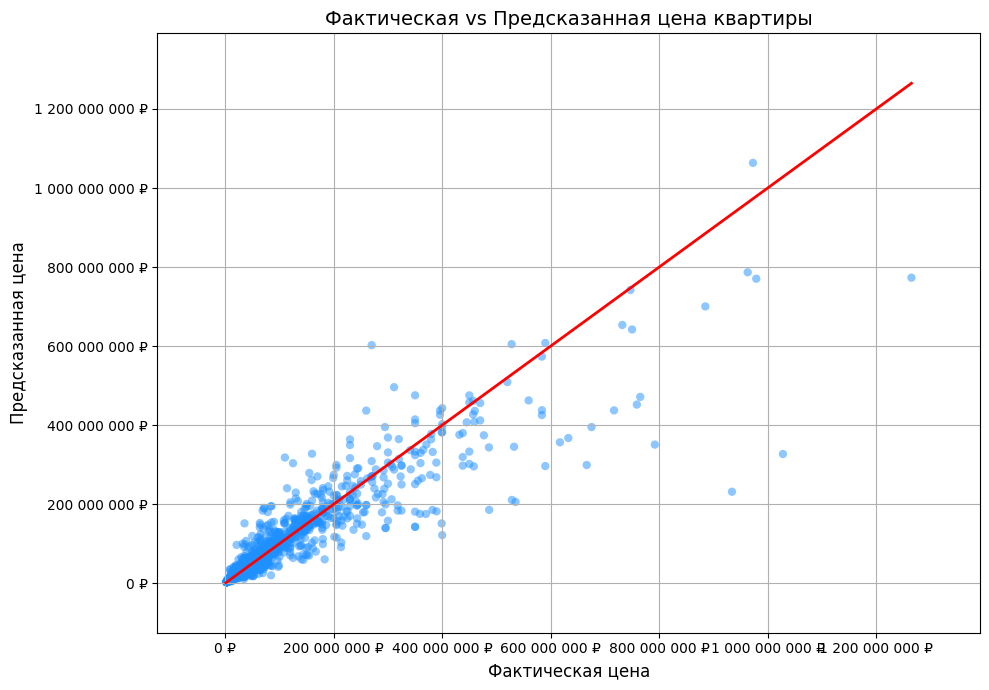

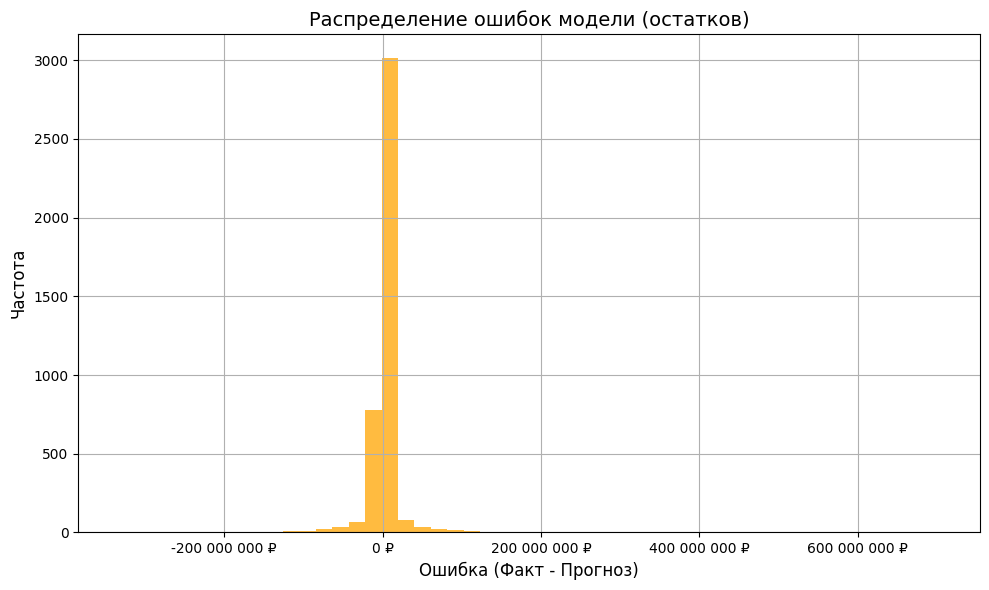

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

# Функция форматирования чисел в рубли
def format_rubles(x, pos):
    return f'{int(x):,} ₽'.replace(',', ' ')

formatter = FuncFormatter(format_rubles)

# Предполагаем, что y_test и y_pred уже определены, например:
y_pred = model.predict(X_test)  # y_pred для тестовой выборки
errors = y_test - y_pred

# Определяем диапазон осей по данным y_test (фактическая цена)
x_min, x_max = y_test.min(), y_test.max()
padding = (x_max - x_min) * 0.1  # 10% от диапазона для отступа
x_lim = (x_min - padding, x_max + padding)
y_lim = x_lim  # для осей, поскольку фактическая и предсказанная цены схожи

# 1. График "Фактическая vs Предсказанная цена"
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred, color='dodgerblue', alpha=0.5, edgecolors='none')
# Линия y = x
plt.plot([x_min, x_max], [x_min, x_max], color='red', lw=2)
plt.xlabel("Фактическая цена", fontsize=12)
plt.ylabel("Предсказанная цена", fontsize=12)
plt.title("Фактическая vs Предсказанная цена квартиры", fontsize=14)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Гистограмма распределения ошибок (остатков)
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, color='orange', alpha=0.75)
plt.xlabel("Ошибка (Факт - Прогноз)", fontsize=12)
plt.ylabel("Частота", fontsize=12)
plt.title("Распределение ошибок модели (остатков)", fontsize=14)
plt.gca().xaxis.set_major_formatter(formatter)
plt.grid(True)
plt.tight_layout()
plt.show()
